In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import cmocean
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [19]:
tau = ['3', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/NoQ'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'dayflat/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

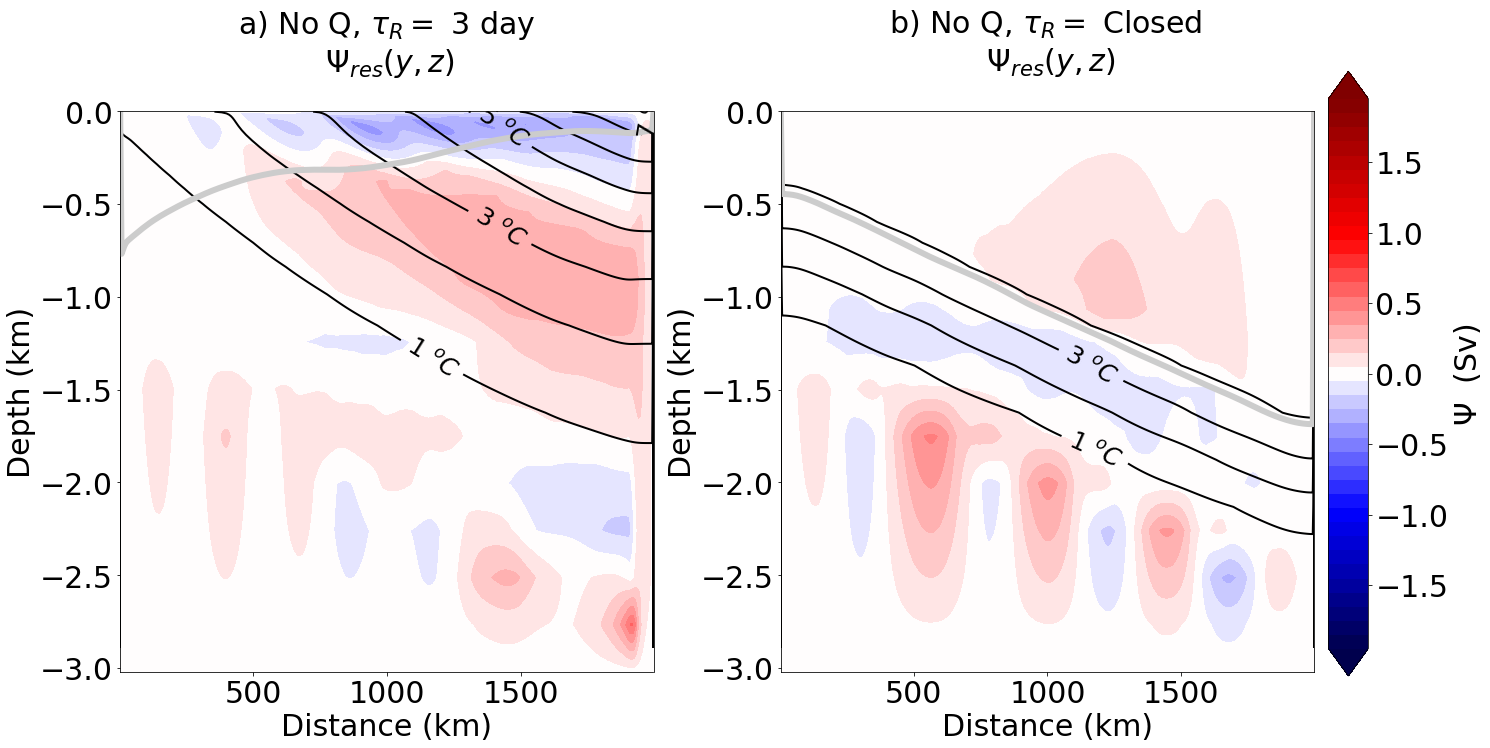

In [20]:
fig = plt.figure(figsize=(18.5, 10.5))
# Create Panels
Psi_levs = np.arange(-2., 2., .1)+0.05
#Psi_levs = np.arange(-2., 2., .21)
Psi_ticks =np.arange(-2., 2., .5)
Q2_levs = (np.arange(-1,8,1))
for i in range(len(Runs)):
    #i =2 
    fname = x+'/'+str(tau[Runs[i]])+'dayflat/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS


    ax = fig.add_subplot(1, 2, i+1)
    Psi = c.get_psi_iso_z()/10**6
    npad = ((0, 1), (0, 0))
    Psi = np.pad(Psi, pad_width=npad, mode='constant', constant_values=0)
   
    p = ax.contourf(c.yc/1000, c.zf/1000,
                Psi, Psi_levs, cmap=plt.cm.seismic, extend='both')
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs, colors='k', linewidths=2)

    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)

    r = ax.plot(c.yc/1000, -mld/1000, scalex=False,
                scaley=False, color='0.8', linestyle='-', linewidth=6)

    
    ax.set_title(str(Figletter[Runs[i]])+r'No Q, $\tau _ R =$ '+str(tau[Runs[i]])+' day \n $\Psi _{res}(y,z)$ \n', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+r'No Q, $\tau _ R =$ '+str(tau[Runs[i]])+' \n $ \Psi _{res}(y,z)$ \n', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less


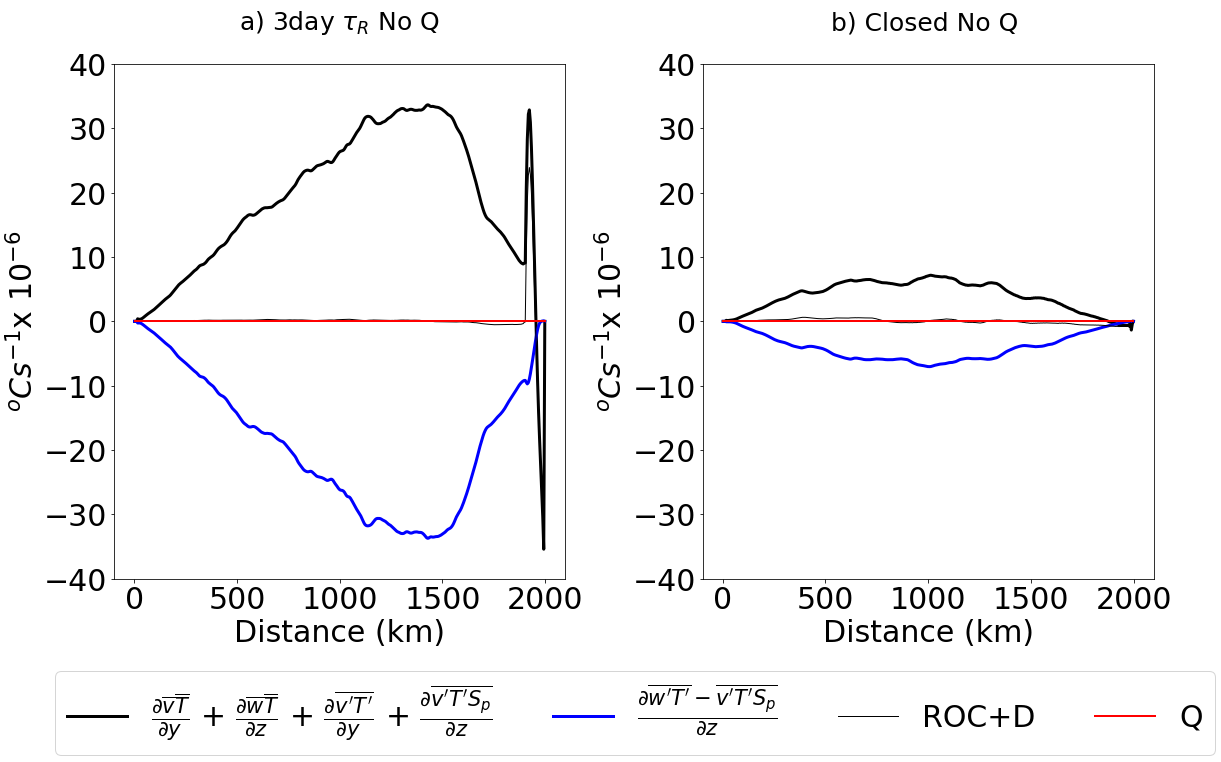

In [26]:
fig = plt.figure(figsize=(16.5, 16.5))
Psi_levs = np.arange(-0., .10, .010)
Psi_ticks = np.arange(-0., .10, .02)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
    #i =2 

    fname = x+'/'+str(tau[Runs[i]])+'dayflat/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    # PLOT PANNEL

    ax = fig.add_subplot(2, 2, i+1)
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    #Div = -((((dVTm + dWTm+dVTe + dWTe)*CellVol/5000).sum(axis=2)).sum(axis=0))/(c.Lx)
    ROC = -((np.nansum(Ade,axis=0) + dVTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0)).sum(axis=1))/sum(CellVol.mean(axis=2))
    D = -((((DE )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = -(Q)/(1000*3985)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'k',linewidth=1)
    p = plt.plot(c.yc/1000,(-Psipred)*10**6,'r',linewidth=2)
    plt.ylim(-40,40)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ No Q' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'Closed No Q' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\frac{\partial \overline{v}\overline{T}}{\partial y }$ + $\frac{\partial \overline{w}\overline{T}}{\partial z }$ + $\frac{\partial \overline{v^{\prime}T^{\prime}}}{\partial y }$ + $ \frac{\partial \overline{v^{\prime}T^{\prime}S_{p}}}{\partial z } $',
                r'$ \frac{\partial \overline{w^{\prime}T^{\prime}}-\overline{v^{\prime}T^{\prime}S_{p}}}{\partial z } $','ROC+D','Q'],loc='upper center', bbox_to_anchor=(-0.15, -0.15),
          fancybox=True, ncol=4,fontsize=30)
plt.tight_layout()

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less


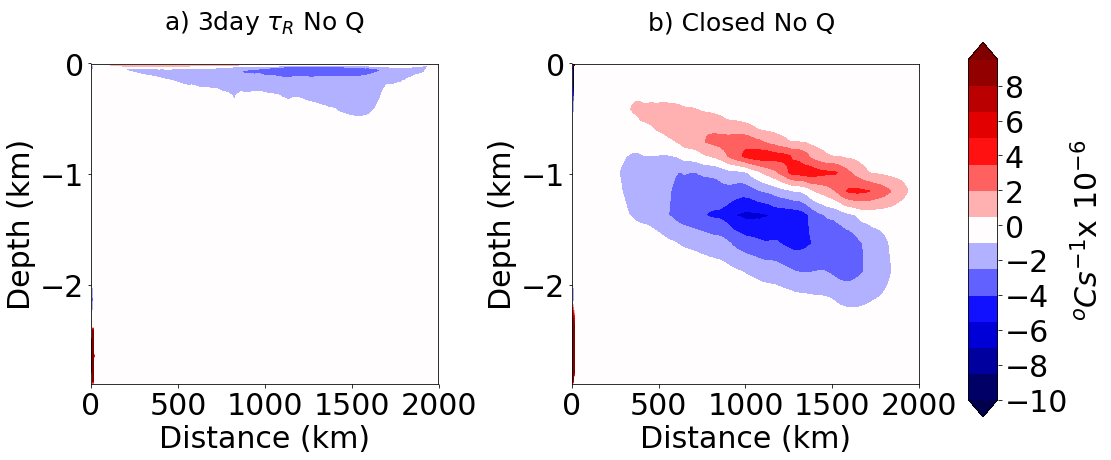

In [39]:
fig = plt.figure(figsize=(13.5, 6.5))
Psi_levs = np.arange(-0., .10, .010)
Psi_ticks = np.arange(-0., .10, .02)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
    #i =2 

    fname = x+'/'+str(tau[Runs[i]])+'dayflat/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    # PLOT PANNEL

    ax = fig.add_subplot(1, 2, i+1)
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]

    ROC = -((np.nansum(Ade,axis=0) + dVTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0)).sum(axis=1))/sum(CellVol.mean(axis=2))
    D = -(((DE )).sum(axis=2))/np.sum(CellVol.mean(axis=2) )
    npad = ((0, 1), (0, 0))
    D = np.pad(D, pad_width=npad, mode='constant', constant_values=0)
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = -(Q)/(1000*3985)
    p = ax.contourf(c.yc/1000, c.zc/1000,
                D*10**6, np.arange(-1,1,0.15)*10, cmap=plt.cm.seismic, extend='both')
    
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ No Q' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'Closed No Q' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax,ticks=np.arange(-1,1,0.2)*10)

cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)
plt.tight_layout()


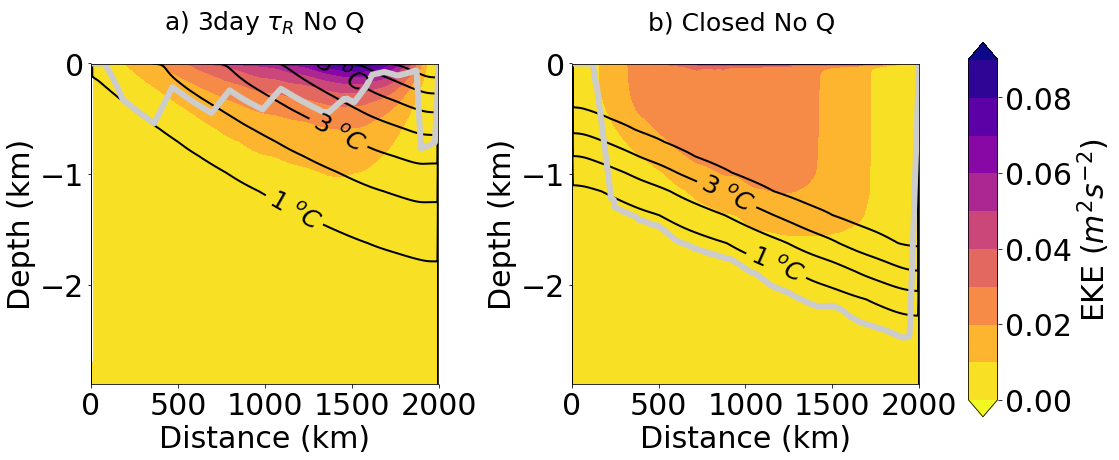

In [42]:
fig = plt.figure(figsize=(13.5, 6.5))
Psi_levs = np.arange(-0., .10, .010)
Psi_ticks = np.arange(-0., .10, .02)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
    #i =2 

    fname = x+'/'+str(tau[Runs[i]])+'dayflat/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    # PLOT PANNEL

    ax = fig.add_subplot(1, 2, i+1)
    #
    # PLOT PANNELS
    EKE = c.calc_EKE()
    EKE[-1,:]=0


    
    Q2_levs = (np.arange(-1, 8, 1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                    EKE, Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    Tavlat = c.get_zonal_avg('Tav.nc', 'THETA')
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs,
                   colors='k', linewidths=2)
    PI = c.mnc('PSI.nc', "LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI, PI < 0.95)
    # Depths
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1], axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if (ma.all(PI[:, jj] == 1) or np.all(psi[:, jj] == -0) or PI[:, jj].mask.all()):
            continue
        indx = ma.nonzero(PI[:, jj] < 1)[0]
        b = indx
        if len(b) >= 2 and (b[1]-b[0]) > 1:
            a = b[1]
        else:
            a = b[0]
        if a < 41 and depths[a-1, jj] - depths[a, jj] > 150:
            a = a - 1
        DDL[jj] = depths[a, jj]
    r = ax.plot(c.yc/1000, SG.savitzky_golay(-DDL/1000, 21, 1), scalex=False,
                scaley=False, color='0.8', linestyle='-', linewidth=6)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' m', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ No Q' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'Closed No Q' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('EKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)
    
